# **Setup Steps** - Required
1. Uncomment the first two code cells (enter the code cell and press `Ctrl a` to highlight all and `Ctrl /` to uncomment the whole cell)
2. Run the first code cell to uninstall the conflicting packages.
3. Run the second code cell to install the package dependencies. This might take several minutes.
4. Restart the notebook runtime before continuing. To do so, open the `Runtime` menu and click `Restart runtime` in the drop-down menu as shown in the image below. Once the notebook kernel restarts do not run the first two code cells again.
![google-colab-restart-notebook-runtime](https://github.com/cj-mills/christianjmills/raw/master/images/icevision-openvino-unity-tutorial/part-1/google-colab-restart-notebook-runtime.png)
5. Re-comment the first two code cells (enter the code cell and press `Ctrl a` to highlight all and `Ctrl /` to comment the whole cell).
6. Execute the notebook starting from the `from icevision.all import *` cell.
7. You will know everything is working if the `from icevision.all import *` cell has the following output.
```text
INFO     - Downloading default `.ttf` font file - SpaceGrotesk-Medium.ttf from https://raw.githubusercontent.com/airctic/storage/master/SpaceGrotesk-Medium.ttf to /root/.icevision/fonts/SpaceGrotesk-Medium.ttf | icevision.visualize.utils:get_default_font:70
INFO     - Downloading mmdet configs | icevision.models.mmdet.download_configs:download_mmdet_configs:31
```
8. Make sure you have a Kaggle API key so you can download the dataset from Kaggle. ([steps](https://christianjmills.com/Fastai-to-Unity-Tutorial-1/#configure-kaggle-api))

**Uninstall conflicting packages**

In [1]:
# %%capture 
# !pip uninstall tensorflow -y
# !pip uninstall thinc -y
# !pip uninstall fastai -y
# !pip uninstall fastcore -y
# !pip uninstall spacy -y
# !pip uninstall en-core-web-sm -y
# !pip uninstall torchtext -y

**Install Dependencies**

In [2]:
# %%capture
# !pip install -U torch==1.10.0+cu111 torchvision==0.11.1+cu111 -f https://download.pytorch.org/whl/torch_stable.html
# !pip install mmcv-full==1.3.17 -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
# !pip install mmdet==2.17.0
# !pip install icevision==0.11.0
# !pip install icedata==0.5.1
# !pip install -U setuptools==59.5.0
# !pip install openvino-dev
# !pip install distinctipy
# !pip install -U pillow
# !pip install -U numpy
# !pip install onnxruntime
# !pip install onnx-simplifier

# **Required:** Restart the notebook after installing dependencies and do not rerun the above code cells

**Import IceVision library**

In [3]:
from icevision.all import *

INFO     - The mmdet config folder already exists. No need to downloaded it. Path : /home/innom-dt/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs | icevision.models.mmdet.download_configs:download_mmdet_configs:17


In [4]:
import pandas as pd
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### Kaggle API
* [GitHub Repository](https://github.com/Kaggle/kaggle-api)
* [Documentation](https://github.com/Kaggle/kaggle-api#competitions)
* Install: `pip install kaggle`
* Need to get an API Key for your Kaggle account
    * [https://www.kaggle.com/me/account](https://www.kaggle.com/me/account)

**Enter Kaggle username and API token**

In [5]:
creds = '{"username":"","key":""}'

**Save Kaggle credentials if none are present**
* **Source:** [https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb)

In [6]:
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
# Save API key to a json file if it does not already exist
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

**Import Kaggle API**

In [7]:
from kaggle import api

**Define path to dataset**

In [8]:
from fastai.data.external import URLs

In [9]:
dataset_name = 'hagrid-sample-30k-384p'
# dataset_name = 'hagrid-sample-120k-384p'
kaggle_dataset = f'innominate817/{dataset_name}'
archive_dir = URLs.path()
dataset_dir = archive_dir/'../data'
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

**Define method to extract the dataset from an archive file**

In [10]:
def file_extract(fname, dest=None):
    "Extract `fname` to `dest` using `tarfile` or `zipfile`."
    if dest is None: dest = Path(fname).parent
    fname = str(fname)
    if   fname.endswith('gz'):  tarfile.open(fname, 'r:gz').extractall(dest)
    elif fname.endswith('zip'): zipfile.ZipFile(fname     ).extractall(dest)
    else: raise Exception(f'Unrecognized archive: {fname}')

**Download the dataset if it is not present**

In [11]:
if not archive_path.exists():
    api.dataset_download_cli(kaggle_dataset, path=archive_dir)
    file_extract(fname=archive_path, dest=dataset_dir)

In [12]:
dir_content = list(dataset_path.ls())
annotation_dir = dataset_path/'ann_train_val'
dir_content.remove(annotation_dir)
img_dir = dir_content[0]
annotation_dir, img_dir

(Path('/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/ann_train_val'),
 Path('/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/hagrid_30k'))

**Inspect the annotation folder**

In [13]:
pd.DataFrame([file.name for file in list(annotation_dir.ls())])

0
0              fist.json
1               one.json
2              rock.json
3     stop_inverted.json
4              like.json
5            two_up.json
6   two_up_inverted.json
7             peace.json
8              stop.json
9              four.json
10          dislike.json
11             palm.json
12             call.json
13           three2.json
14               ok.json
15             mute.json
16            three.json
17   peace_inverted.json

**Inspect the annotation folder**

In [14]:
pd.DataFrame([folder.name for folder in list(img_dir.ls())])

0
0             train_val_peace
1              train_val_palm
2               train_val_one
3            train_val_three2
4     train_val_stop_inverted
5    train_val_peace_inverted
6           train_val_dislike
7              train_val_fist
8              train_val_rock
9            train_val_two_up
10             train_val_stop
11             train_val_like
12             train_val_mute
13             train_val_call
14               train_val_ok
15            train_val_three
16             train_val_four
17  train_val_two_up_inverted

**Get image file paths**

In [15]:
files = get_image_files(img_dir)
len(files)

31833

**Inspect files**

In [16]:
pd.DataFrame([files[0], files[-1]])

0
0             /home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/hagrid_30k/train_val_call/00005c9c-3548-4a8f-9d0b-2dd4aff37fc9.jpg
1  /home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/hagrid_30k/train_val_two_up_inverted/fff4d2f6-9890-4225-8d9c-73a02ba8f9ac.jpg

**Inspect one of the training images**

Image Dims: (512, 384)


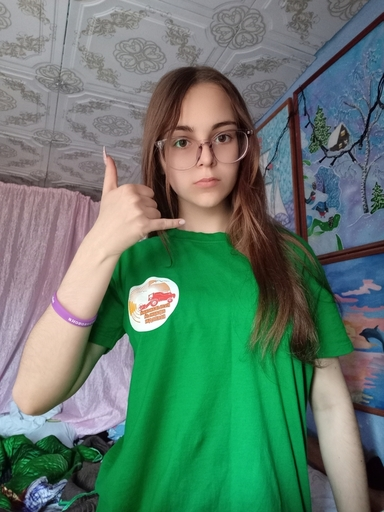

In [17]:
import PIL
img = PIL.Image.open(files[0]).convert('RGB')
print(f"Image Dims: {img.shape}")
img

**Create a dictionary that maps image names to file paths**

In [18]:
img_dict = {file.name.split('.')[0] : file for file in files}
list(img_dict.items())[0]

('00005c9c-3548-4a8f-9d0b-2dd4aff37fc9',
 Path('/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/hagrid_30k/train_val_call/00005c9c-3548-4a8f-9d0b-2dd4aff37fc9.jpg'))

**Get list of annotation file paths**

In [19]:
import os
from glob import glob

In [20]:
annotation_paths = glob(os.path.join(annotation_dir, "*.json"))
annotation_paths

['/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/ann_train_val/fist.json',
 '/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/ann_train_val/one.json',
 '/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/ann_train_val/rock.json',
 '/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/ann_train_val/stop_inverted.json',
 '/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/ann_train_val/like.json',
 '/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/ann_train_val/two_up.json',
 '/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/ann_train_val/two_up_inverted.json',
 '/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/ann_train_val/peace.json',
 '/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/ann_train_val/stop.json',
 '/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/ann_train_val/four.json',
 '/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/ann_train_val/

**Create annotation dataframe**

In [21]:
cls_dataframes = (pd.read_json(f).transpose() for f in annotation_paths)
annotation_df = pd.concat(cls_dataframes, ignore_index=False)
annotation_df = annotation_df.loc[list(img_dict.keys())]
annotation_df.head()

bboxes  \
00005c9c-3548-4a8f-9d0b-2dd4aff37fc9                                                                    [[0.23925175, 0.28595301, 0.25055143, 0.20777627]]   
0020a3db-82d8-47aa-8642-2715d4744db5                                                            [[0.5801012999999999, 0.53265105, 0.14562138, 0.12286348]]   
004ac93f-0f7c-49a4-aadc-737e0ad4273c                                                           [[0.46294793, 0.26419774, 0.13834939000000002, 0.10784189]]   
006cac69-d3f0-47f9-aac9-38702d038ef1                                                                    [[0.38799208, 0.44643898, 0.27068787, 0.18277858]]   
00973fac-440e-4a56-b60c-2a06d5fb155d  [[0.40980118, 0.38144198, 0.08338464, 0.06229785], [0.6122035100000001, 0.6780825500000001, 0.04700606, 0.07640522]]   

                                                  labels leading_hand  \
00005c9c-3548-4a8f-9d0b-2dd4aff37fc9              [call]        right   
0020a3db-82d8-47aa-8642-2715d4744db5              [call]         left   
004ac93f-0f7c-49a4-aadc-737e0ad4273c              [call]        right   
006cac69-d3f0-47f9-aac9-38702d038ef1              [call]        right   
00973fac-440e-4a56-b60c-2a06d5fb155d  [call, no_gesture]        right   

                                     leading_conf  \
00005c9c-3548-4a8f-9d0b-2dd4aff37fc9            1   
0020a3db-82d8-47aa-8642-2715d4744db5            1   
004ac93f-0f7c-49a4-aadc-737e0ad4273c            1   
006cac69-d3f0-47f9-aac9-38702d038ef1            1   
00973fac-440e-4a56-b60c-2a06d5fb155d            1   

                                                                                               user_id  
00005c9c-3548-4a8f-9d0b-2dd4aff37fc9  5a389ffe1bed6660a59f4586c7d8fe2770785e5bf79b09334aa951f6f119c024  
0020a3db-82d8-47aa-8642-2715d4744db5  0d6da2c87ef8eabeda2dcfee2dc5b5035e878137a91b149c754a59804f3dce32  
004ac93f-0f7c-49a4-aadc-737e0ad4273c  d50f05d9d6ca9771938cec766c3d621ff863612f9665b0e4d991c086ec04acc9  
006cac69-d3f0-47f9-aac9-38702d038ef1  998f6ad69140b3a59cb9823ba680cce62bf2ba678058c2fc497dbbb8b22b29fe  
00973fac-440e-4a56-b60c-2a06d5fb155d  4bb3ee1748be58e05bd1193939735e57bb3c0ca59a7ee38901744d6b9e94632e

In [22]:
file_id = files[0].name.split('.')[0]
file_id

'00005c9c-3548-4a8f-9d0b-2dd4aff37fc9'

In [23]:
annotation_df.loc[file_id].to_frame()

00005c9c-3548-4a8f-9d0b-2dd4aff37fc9
bboxes                      [[0.23925175, 0.28595301, 0.25055143, 0.20777627]]
labels                                                                  [call]
leading_hand                                                             right
leading_conf                                                                 1
user_id       5a389ffe1bed6660a59f4586c7d8fe2770785e5bf79b09334aa951f6f119c024

**Download font file**

In [24]:
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'
if not os.path.exists(font_file): 
    !wget https://fonts.gstatic.com/s/roboto/v30/$font_file

**Annotate sample image**

In [25]:
from PIL import ImageDraw

(384, 512)


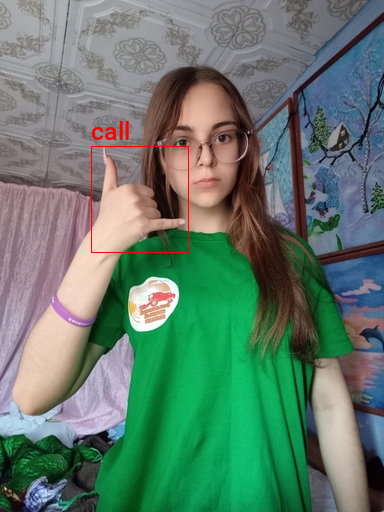

In [26]:
width, height = img.size
annotated_img = img.copy()
draw = ImageDraw.Draw(annotated_img)
fnt_size = 25
annotation = annotation_df.loc[file_id]

for i in range(len(annotation['labels'])):
    x, y, w, h = annotation['bboxes'][i]
    x *= width
    y *= height
    w *= width
    h *= height
    shape = (x, y, x+w, y+h)
    draw.rectangle(shape, outline='red')
    fnt = PIL.ImageFont.truetype(font_file, fnt_size)
    draw.multiline_text((x, y-fnt_size-5), f"{annotation['labels'][i]}", font=fnt, fill='red')
print(annotated_img.size) 
annotated_img

**Create a class map**

In [27]:
labels = annotation_df['labels'].explode().unique().tolist()
labels

['call',
 'no_gesture',
 'dislike',
 'fist',
 'four',
 'like',
 'mute',
 'ok',
 'one',
 'palm',
 'peace',
 'peace_inverted',
 'rock',
 'stop',
 'stop_inverted',
 'three',
 'three2',
 'two_up',
 'two_up_inverted']

In [28]:
class_map = ClassMap(labels)
class_map

<ClassMap: {'background': 0, 'call': 1, 'no_gesture': 2, 'dislike': 3, 'fist': 4, 'four': 5, 'like': 6, 'mute': 7, 'ok': 8, 'one': 9, 'palm': 10, 'peace': 11, 'peace_inverted': 12, 'rock': 13, 'stop': 14, 'stop_inverted': 15, 'three': 16, 'three2': 17, 'two_up': 18, 'two_up_inverted': 19}>

**Note:** The `background` class is not included in the final model.

**View template for an object detection record**

In [29]:
template_record = ObjectDetectionRecord()
template_record

BaseRecord

common: 
	- Filepath: None
	- Img: None
	- Record ID: None
	- Image size None
detection: 
	- BBoxes: []
	- Class Map: None
	- Labels: []

**View template for an object detection parser**

In [30]:
Parser.generate_template(template_record)

class MyParser(Parser):
    def __init__(self, template_record):
        super().__init__(template_record=template_record)
    def __iter__(self) -> Any:
    def __len__(self) -> int:
    def record_id(self, o: Any) -> Hashable:
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        record.set_filepath(<Union[str, Path]>)
        record.set_img_size(<ImgSize>)
        record.detection.add_bboxes(<Sequence[BBox]>)
        record.detection.set_class_map(<ClassMap>)
        record.detection.add_labels(<Sequence[Hashable]>)


**Define custom parser class**

In [31]:
class HagridParser(Parser):
    def __init__(self, template_record, annotations_df, img_dict, class_map):
        super().__init__(template_record=template_record)
        self.img_dict = img_dict
        self.df = annotations_df
        self.class_map = class_map
    def __iter__(self) -> Any:
        for o in self.df.itertuples(): yield o
    
    def __len__(self) -> int: 
        return len(self.df)
    
    def record_id(self, o: Any) -> Hashable:
        return o.Index
    
    def parse_fields(self, o: Any, record: BaseRecord, is_new: bool):
        
        filepath = self.img_dict[o.Index]
        
        width, height = PIL.Image.open(filepath).convert('RGB').size
        
        record.set_img_size(ImgSize(width=width, height=height))
        record.set_filepath(filepath)
        record.detection.set_class_map(self.class_map)
        
        record.detection.add_labels(o.labels)
        bbox_list = []
        
        for i, label in enumerate(o.labels):
            x = o.bboxes[i][0]*width
            y = o.bboxes[i][1]*height
            w = o.bboxes[i][2]*width
            h = o.bboxes[i][3]*height
            bbox_list.append( BBox.from_xywh(x, y, w, h))
        record.detection.add_bboxes(bbox_list)
            

**Create a custom parser object**

In [32]:
parser = HagridParser(template_record, annotation_df, img_dict, class_map)
len(parser)

31833

**Parse annotations to create records**

In [33]:
# Randomly split our data into train/valid
data_splitter = RandomSplitter([0.8, 0.2])

train_records, valid_records = parser.parse(data_splitter, cache_filepath=f'{dataset_name}-cache.pkl')

INFO     - Loading cached records from hagrid-sample-30k-384p-cache.pkl | icevision.parsers.parser:parse:113


In [34]:
train_records[0]

BaseRecord

common: 
	- Filepath: /mnt/980SSD_1TB_2/Datasets/hagrid-sample-30k-384p/hagrid_30k/train_val_one/2507aacb-43d2-4114-91f1-008e3c7a181c.jpg
	- Img: None
	- Record ID: 2507aacb-43d2-4114-91f1-008e3c7a181c
	- Image size ImgSize(width=640, height=853)
detection: 
	- BBoxes: [<BBox (xmin:153.0572608, ymin:197.40873228, xmax:213.5684992, ymax:320.45228481000004)>, <BBox (xmin:474.20276479999995, ymin:563.67557885, xmax:520.8937472, ymax:657.61167499)>]
	- Class Map: <ClassMap: {'background': 0, 'call': 1, 'no_gesture': 2, 'dislike': 3, 'fist': 4, 'four': 5, 'like': 6, 'mute': 7, 'ok': 8, 'one': 9, 'palm': 10, 'peace': 11, 'peace_inverted': 12, 'rock': 13, 'stop': 14, 'stop_inverted': 15, 'three': 16, 'three2': 17, 'two_up': 18, 'two_up_inverted': 19}>
	- Labels: [9, 2]

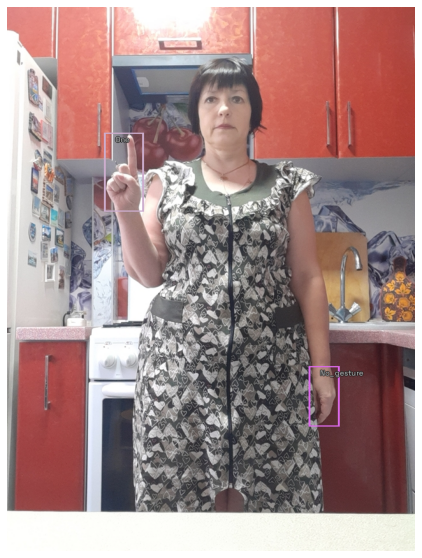

In [35]:
show_record(train_records[0], figsize = (10,10), display_label=True )

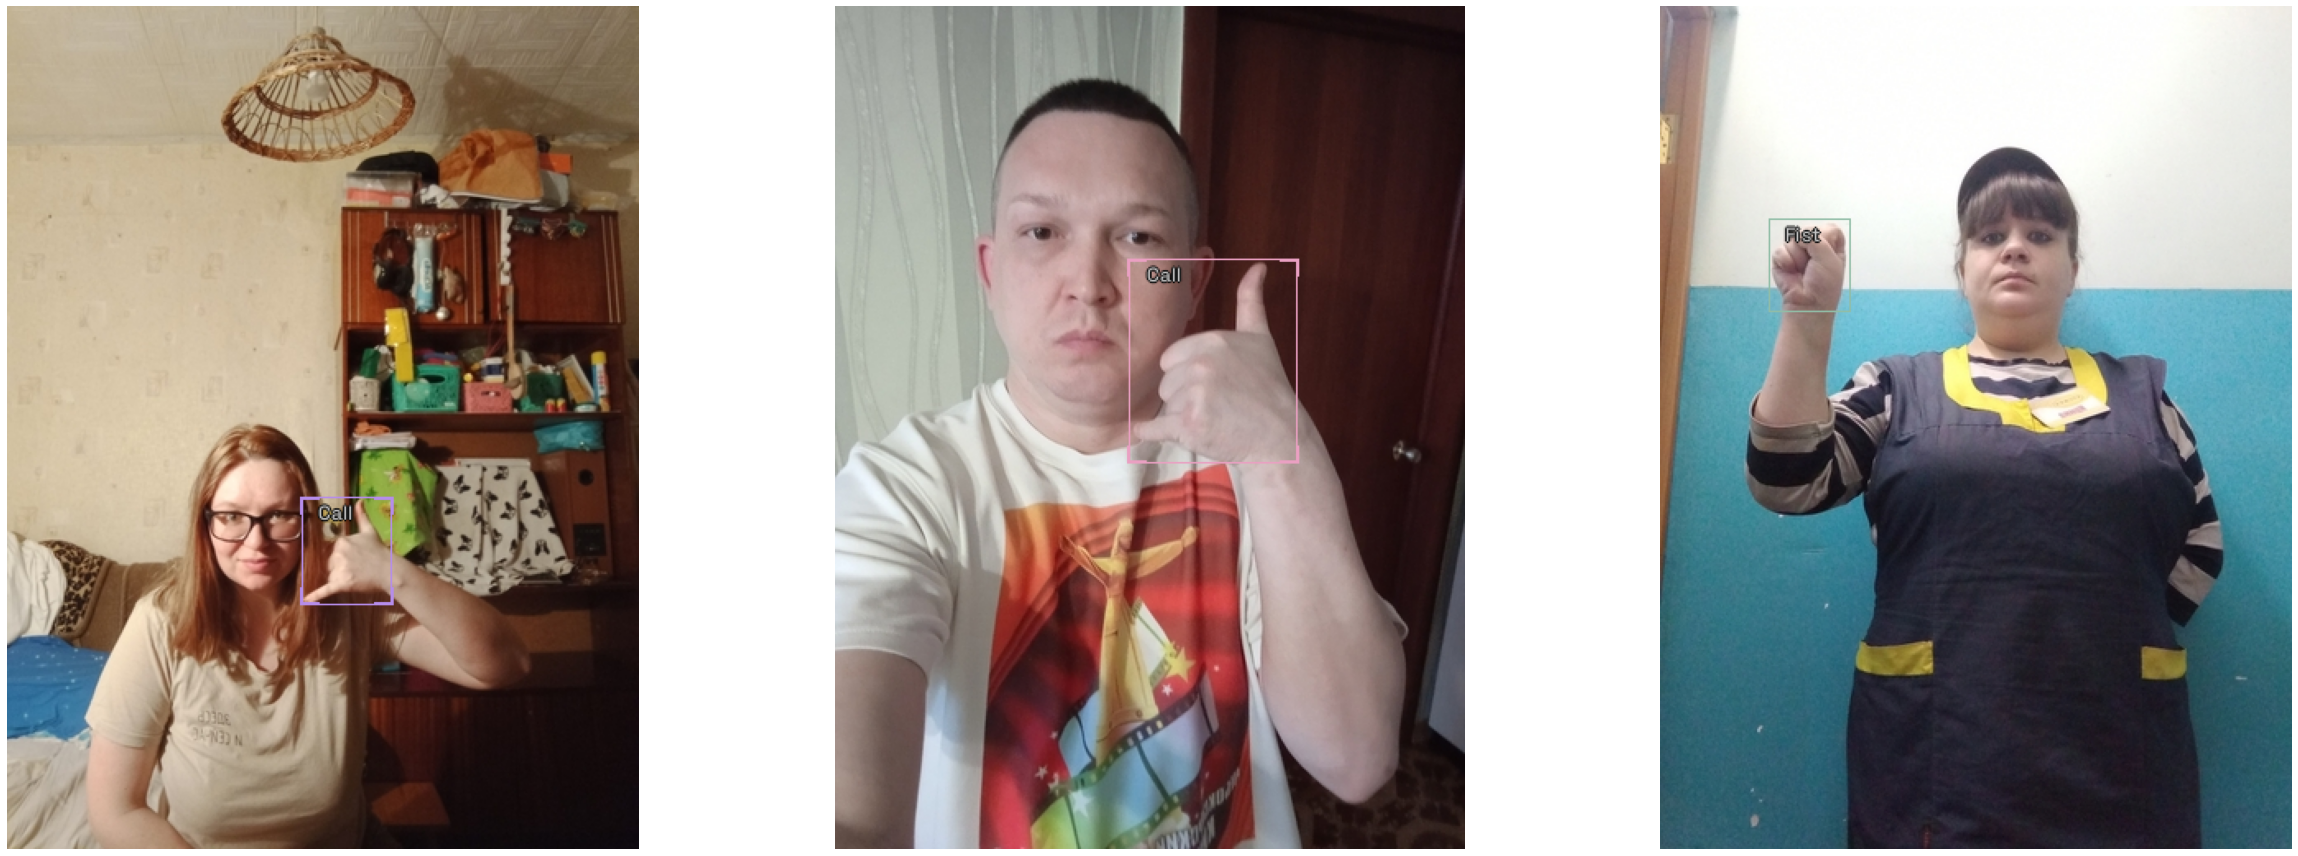

In [36]:
show_records(train_records[1:4], ncols=3,display_label=True)

**Define stride values**

In [37]:
strides = [8, 16, 32]
max_stride = max(strides)

**Select a multiple of the max stride value as the input resolution**

In [38]:
[max_stride*i for i in range(7,21)]

[224, 256, 288, 320, 352, 384, 416, 448, 480, 512, 544, 576, 608, 640]

In [39]:
image_size = 384
presize = 512

**Define Transforms**

In [40]:
pd.DataFrame(tfms.A.aug_tfms(size=image_size, presize=presize))

0
0                                                                                                                                                                                      SmallestMaxSize(always_apply=False, p=1, max_size=512, interpolation=1)
1                                                                                                                                                                                                                    HorizontalFlip(always_apply=False, p=0.5)
2  ShiftScaleRotate(always_apply=False, p=0.5, shift_limit_x=(-0.0625, 0.0625), shift_limit_y=(-0.0625, 0.0625), scale_limit=(-0.09999999999999998, 0.10000000000000009), rotate_limit=(-15, 15), interpolation=1, border_mode=4, value=None, mask_value=None)
3                                                                                                                                               RGBShift(always_apply=False, p=0.5, r_shift_limit=(-10, 10), g_shift_limit=(-10, 10), b_shift_limit=(-10, 10))
4                                                                                                                        RandomBrightnessContrast(always_apply=False, p=0.5, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True)
5                                                                                                                                                                                                           Blur(always_apply=False, p=0.5, blur_limit=(1, 3))
6                                          OneOrOther([\n  RandomSizedBBoxSafeCrop(always_apply=False, p=0.5, height=384, width=384, erosion_rate=0.0, interpolation=1),\n  LongestMaxSize(always_apply=False, p=1, max_size=384, interpolation=1),\n], p=0.5)
7                                                                                PadIfNeeded(always_apply=False, p=1.0, min_height=384, min_width=384, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=[124, 116, 104], mask_value=None)

In [41]:
pd.DataFrame(tfms.A.resize_and_pad(size=image_size))

0
0                                                                                                         LongestMaxSize(always_apply=False, p=1, max_size=384, interpolation=1)
1  PadIfNeeded(always_apply=False, p=1.0, min_height=384, min_width=384, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=[124, 116, 104], mask_value=None)

In [42]:
train_tfms = tfms.A.Adapter([*tfms.A.aug_tfms(size=image_size, presize=presize), tfms.A.Normalize()])
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(image_size), tfms.A.Normalize()])

**Get normalization stats**

In [43]:
mean = tfms.A.Normalize().mean
std = tfms.A.Normalize().std
mean, std

((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

**Define Datasets**

In [44]:
train_ds = Dataset(train_records, train_tfms)
valid_ds = Dataset(valid_records, valid_tfms)
train_ds, valid_ds

(<Dataset with 25466 items>, <Dataset with 6367 items>)

**Apply augmentations to a training sample**

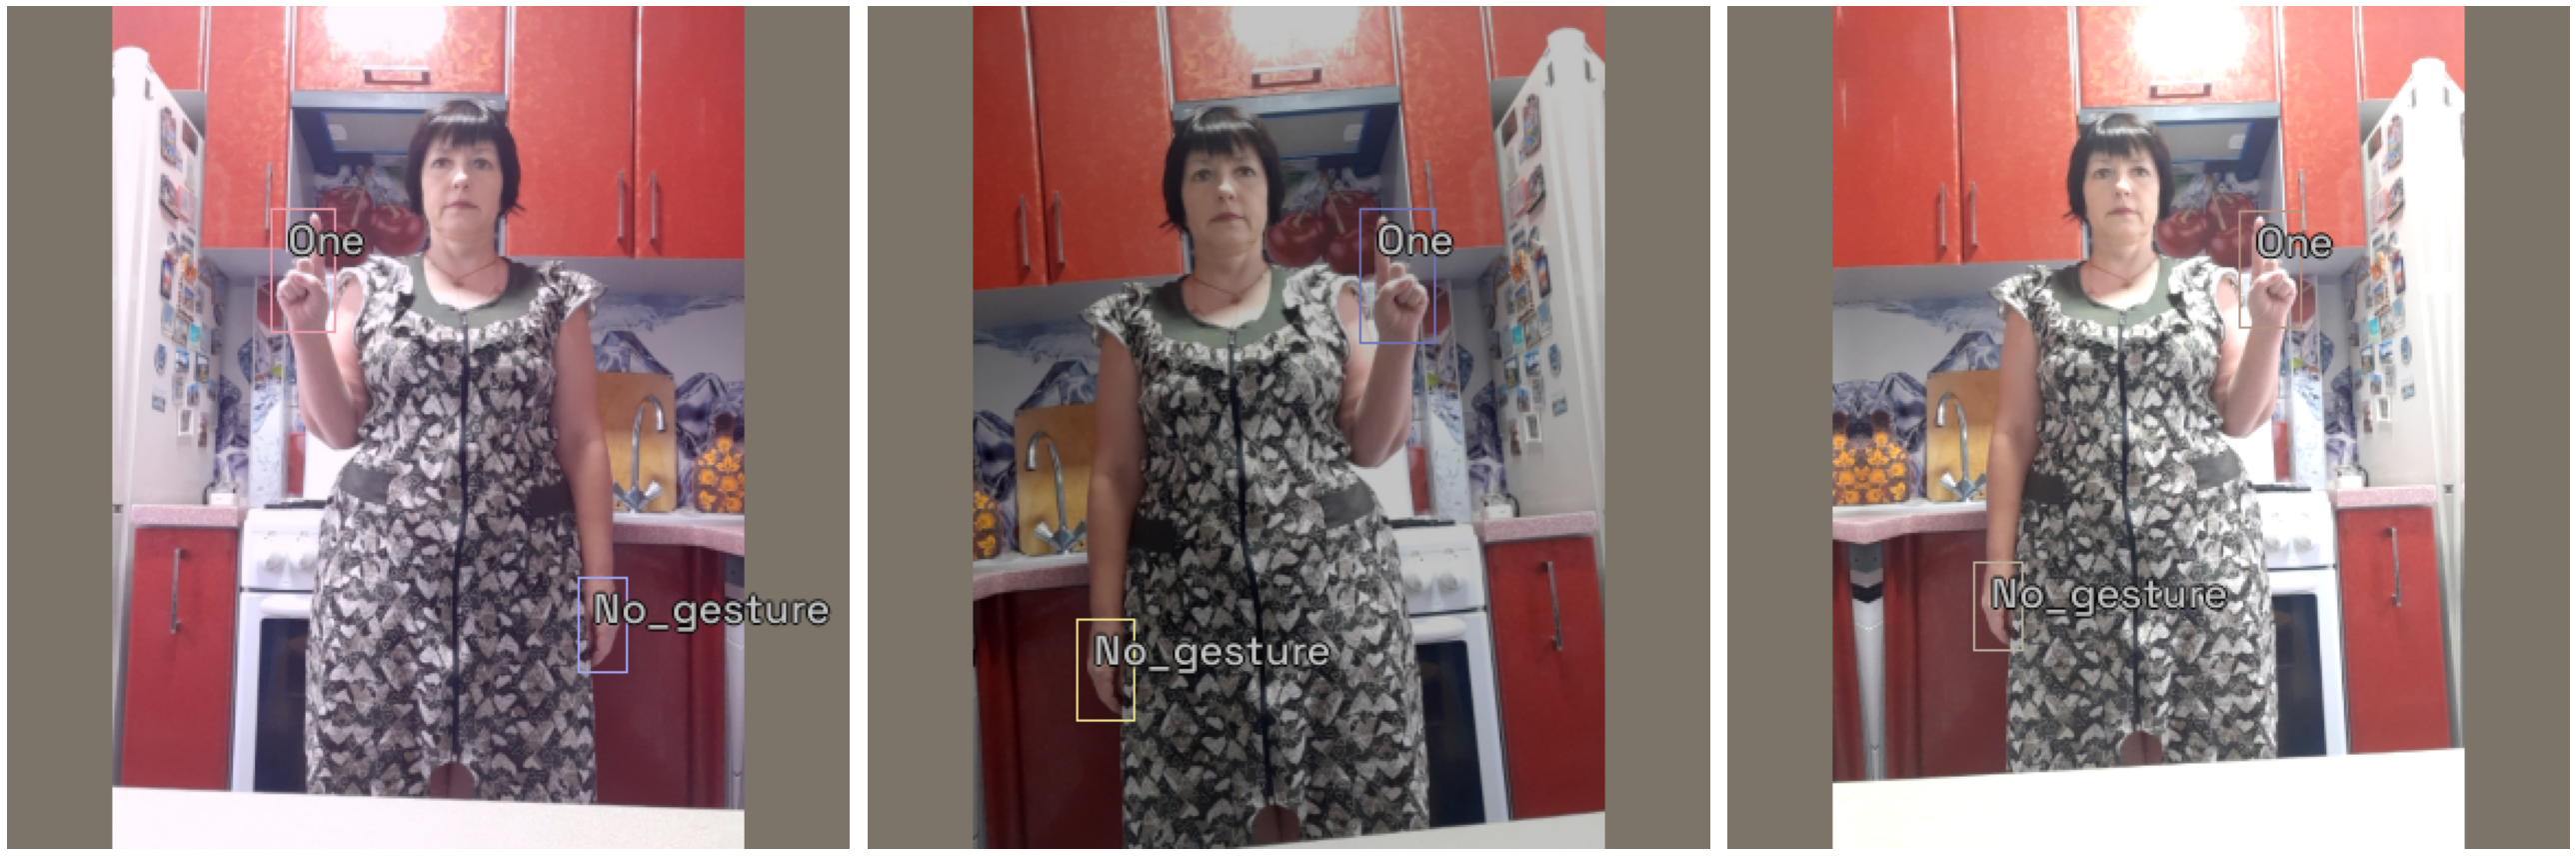

In [45]:
samples = [train_ds[0] for _ in range(3)]
show_samples(samples, ncols=3)

**Define model type**

In [46]:
model_type = models.mmdet.yolox

**Define backbone**

In [47]:
backbone = model_type.backbones.yolox_tiny_8x8(pretrained=True)
pd.DataFrame.from_dict(backbone.__dict__, orient='index')

0
model_name                                                                                                                                  yolox
config_path                    /home/innom-dt/.icevision/mmdetection_configs/mmdetection_configs-2.16.0/configs/yolox/yolox_tiny_8x8_300e_coco.py
weights_url  https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_tiny_8x8_300e_coco/yolox_tiny_8x8_300e_coco_20210806_234250-4ff3b67e.pth
pretrained                                                                                                                                   True

**Define batch size**

In [48]:
bs = 32

**Define DataLoaders**

In [49]:
train_dl = model_type.train_dl(train_ds, batch_size=bs, num_workers=2, shuffle=True)
valid_dl = model_type.valid_dl(valid_ds, batch_size=bs, num_workers=2, shuffle=False)

**Instantiate the model**

In [50]:
extra_args = {}

In [51]:
model = model_type.model(backbone=backbone(pretrained=True), num_classes=len(parser.class_map), **extra_args) 

2022-08-04 12:53:47,045 - mmcv - INFO - initialize CSPDarknet with init_cfg {'type': 'Kaiming', 'layer': 'Conv2d', 'a': 2.23606797749979, 'distribution': 'uniform', 'mode': 'fan_in', 'nonlinearity': 'leaky_relu'}
2022-08-04 12:53:47,059 - mmcv - INFO - initialize YOLOXPAFPN with init_cfg {'type': 'Kaiming', 'layer': 'Conv2d', 'a': 2.23606797749979, 'distribution': 'uniform', 'mode': 'fan_in', 'nonlinearity': 'leaky_relu'}
2022-08-04 12:53:47,070 - mmcv - INFO - initialize YOLOXHead with init_cfg {'type': 'Kaiming', 'layer': 'Conv2d', 'a': 2.23606797749979, 'distribution': 'uniform', 'mode': 'fan_in', 'nonlinearity': 'leaky_relu'}
2022-08-04 12:53:47,076 - mmcv - INFO - 
backbone.stem.conv.conv.weight - torch.Size([24, 12, 3, 3]): 
KaimingInit: a=2.23606797749979, mode=fan_in, nonlinearity=leaky_relu, distribution =uniform, bias=0 
 
2022-08-04 12:53:47,077 - mmcv - INFO - 
backbone.stem.conv.bn.weight - torch.Size([24]): 
The value is the same before and after calling `init_weights` of

2022-08-04 12:53:47,090 - mmcv - INFO - 
backbone.stage2.1.blocks.1.conv1.bn.bias - torch.Size([48]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,090 - mmcv - INFO - 
backbone.stage2.1.blocks.1.conv2.conv.weight - torch.Size([48, 48, 3, 3]): 
KaimingInit: a=2.23606797749979, mode=fan_in, nonlinearity=leaky_relu, distribution =uniform, bias=0 
 
2022-08-04 12:53:47,090 - mmcv - INFO - 
backbone.stage2.1.blocks.1.conv2.bn.weight - torch.Size([48]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,090 - mmcv - INFO - 
backbone.stage2.1.blocks.1.conv2.bn.bias - torch.Size([48]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,092 - mmcv - INFO - 
backbone.stage2.1.blocks.2.conv1.conv.weight - torch.Size([48, 48, 1, 1]): 
KaimingInit: a=2.23606797749979, mode=fan_in, nonlinearity=leaky_relu, distribution =uniform, bias=0 
 
2022-08-04 12:53:47,09

2022-08-04 12:53:47,103 - mmcv - INFO - 
backbone.stage4.1.conv1.bn.weight - torch.Size([192]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,103 - mmcv - INFO - 
backbone.stage4.1.conv1.bn.bias - torch.Size([192]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,104 - mmcv - INFO - 
backbone.stage4.1.conv2.conv.weight - torch.Size([384, 768, 1, 1]): 
KaimingInit: a=2.23606797749979, mode=fan_in, nonlinearity=leaky_relu, distribution =uniform, bias=0 
 
2022-08-04 12:53:47,104 - mmcv - INFO - 
backbone.stage4.1.conv2.bn.weight - torch.Size([384]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,104 - mmcv - INFO - 
backbone.stage4.1.conv2.bn.bias - torch.Size([384]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,105 - mmcv - INFO - 
backbone.stage4.2.main_conv.conv.weight - torch.Size([192, 38

2022-08-04 12:53:47,115 - mmcv - INFO - 
neck.top_down_blocks.1.main_conv.bn.bias - torch.Size([48]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,115 - mmcv - INFO - 
neck.top_down_blocks.1.short_conv.conv.weight - torch.Size([48, 192, 1, 1]): 
KaimingInit: a=2.23606797749979, mode=fan_in, nonlinearity=leaky_relu, distribution =uniform, bias=0 
 
2022-08-04 12:53:47,115 - mmcv - INFO - 
neck.top_down_blocks.1.short_conv.bn.weight - torch.Size([48]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,115 - mmcv - INFO - 
neck.top_down_blocks.1.short_conv.bn.bias - torch.Size([48]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,117 - mmcv - INFO - 
neck.top_down_blocks.1.final_conv.conv.weight - torch.Size([96, 96, 1, 1]): 
KaimingInit: a=2.23606797749979, mode=fan_in, nonlinearity=leaky_relu, distribution =uniform, bias=0 
 
2022-08-04 12:53:

2022-08-04 12:53:47,126 - mmcv - INFO - 
neck.bottom_up_blocks.1.blocks.0.conv1.conv.weight - torch.Size([192, 192, 1, 1]): 
KaimingInit: a=2.23606797749979, mode=fan_in, nonlinearity=leaky_relu, distribution =uniform, bias=0 
 
2022-08-04 12:53:47,126 - mmcv - INFO - 
neck.bottom_up_blocks.1.blocks.0.conv1.bn.weight - torch.Size([192]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,126 - mmcv - INFO - 
neck.bottom_up_blocks.1.blocks.0.conv1.bn.bias - torch.Size([192]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,126 - mmcv - INFO - 
neck.bottom_up_blocks.1.blocks.0.conv2.conv.weight - torch.Size([192, 192, 3, 3]): 
KaimingInit: a=2.23606797749979, mode=fan_in, nonlinearity=leaky_relu, distribution =uniform, bias=0 
 
2022-08-04 12:53:47,127 - mmcv - INFO - 
neck.bottom_up_blocks.1.blocks.0.conv2.bn.weight - torch.Size([192]): 
The value is the same before and after calling `init_weigh

2022-08-04 12:53:47,140 - mmcv - INFO - 
bbox_head.multi_level_reg_convs.1.1.bn.weight - torch.Size([96]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,140 - mmcv - INFO - 
bbox_head.multi_level_reg_convs.1.1.bn.bias - torch.Size([96]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,140 - mmcv - INFO - 
bbox_head.multi_level_reg_convs.2.0.conv.weight - torch.Size([96, 96, 3, 3]): 
KaimingInit: a=2.23606797749979, mode=fan_in, nonlinearity=leaky_relu, distribution =uniform, bias=0 
 
2022-08-04 12:53:47,141 - mmcv - INFO - 
bbox_head.multi_level_reg_convs.2.0.bn.weight - torch.Size([96]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,141 - mmcv - INFO - 
bbox_head.multi_level_reg_convs.2.0.bn.bias - torch.Size([96]): 
The value is the same before and after calling `init_weights` of YOLOX  
 
2022-08-04 12:53:47,142 - mmcv - INFO - 
bbox_he

Use load_from_local loader
The model and loaded state dict do not match exactly

size mismatch for bbox_head.multi_level_conv_cls.0.weight: copying a param with shape torch.Size([80, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([19, 96, 1, 1]).
size mismatch for bbox_head.multi_level_conv_cls.0.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([19]).
size mismatch for bbox_head.multi_level_conv_cls.1.weight: copying a param with shape torch.Size([80, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([19, 96, 1, 1]).
size mismatch for bbox_head.multi_level_conv_cls.1.bias: copying a param with shape torch.Size([80]) from checkpoint, the shape in current model is torch.Size([19]).
size mismatch for bbox_head.multi_level_conv_cls.2.weight: copying a param with shape torch.Size([80, 96, 1, 1]) from checkpoint, the shape in current model is torch.Size([19, 96, 1, 1]).
size mismatch for bbox_

**Define metrics**

In [52]:
metrics = [COCOMetric(metric_type=COCOMetricType.bbox)]

**Define Learner object**

In [53]:
learn = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, metrics=metrics)

**Find learning rate**

SuggestedLRs(valley=0.0004786300996784121)

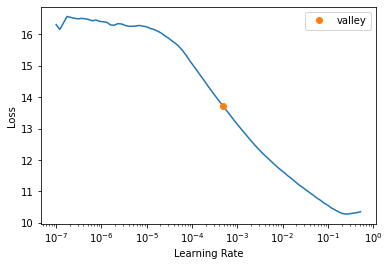

In [54]:
learn.lr_find()

**Define learning rate**

In [55]:
lr = 1e-3

**Define number of epochs**

In [56]:
epochs = 15

**Finetune model**

In [57]:
learn.fine_tune(epochs, lr, freeze_epochs=1)

**Define method to convert a PIL Image to a Pytorch Tensor**

In [59]:
def img_to_tensor(img:PIL.Image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    # Convert image to tensor
    img_tensor = torch.Tensor(np.array(img)).permute(2, 0, 1)
    # Scale pixels values from [0,255] to [0,1]
    scaled_tensor = img_tensor.float().div_(255)
    # Prepare normalization tensors
    mean_tensor = tensor(mean).view(1,1,-1).permute(2, 0, 1)
    std_tensor = tensor(std).view(1,1,-1).permute(2, 0, 1)
    # Normalize tensor    
    normalized_tensor = (scaled_tensor - mean_tensor) / std_tensor
    # Batch tensor
    return normalized_tensor.unsqueeze(dim=0)

**Select a test image**

In [60]:
annotation_df.iloc[4].to_frame()

00973fac-440e-4a56-b60c-2a06d5fb155d
bboxes        [[0.40980118, 0.38144198, 0.08338464, 0.06229785], [0.6122035100000001, 0.6780825500000001, 0.04700606, 0.07640522]]
labels                                                                                                          [call, no_gesture]
leading_hand                                                                                                                 right
leading_conf                                                                                                                     1
user_id                                                           4bb3ee1748be58e05bd1193939735e57bb3c0ca59a7ee38901744d6b9e94632e

In [61]:
test_file = img_dict[annotation_df.iloc[4].name]
test_file

Path('/home/innom-dt/.fastai/archive/../data/hagrid-sample-30k-384p/hagrid_30k/train_val_call/00973fac-440e-4a56-b60c-2a06d5fb155d.jpg')

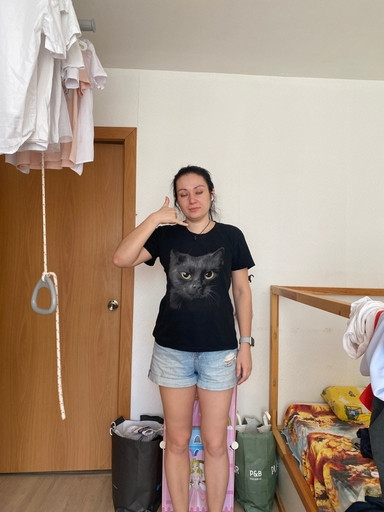

In [62]:
test_img = PIL.Image.open(test_file).convert('RGB')
test_img

**Calculate valid input dimensions**

In [63]:
input_h = test_img.height - (test_img.height % max_stride)
input_w = test_img.width - (test_img.width % max_stride)
input_h, input_w

(512, 384)

**Crop image to supported resolution**

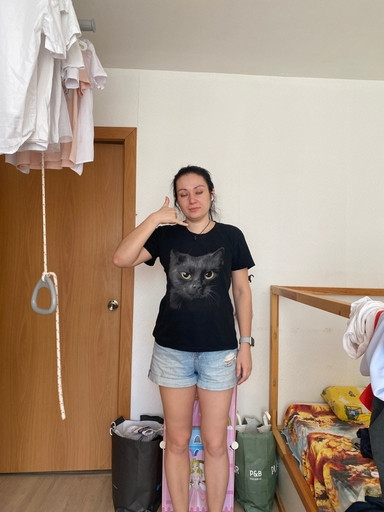

In [64]:
test_img = test_img.crop_pad((input_w, input_h))
test_img

**Convert image to a normalized tensor**

In [65]:
test_tensor = img_to_tensor(test_img, mean=mean, std=std)
test_tensor.shape

torch.Size([1, 3, 512, 384])

**Inspect raw model output**

In [67]:
model_output = model.cpu().forward_dummy(test_tensor.cpu())

In [68]:
for raw_out in model_output:
    for out in raw_out:
        print(out.shape)

torch.Size([1, 19, 64, 48])
torch.Size([1, 19, 32, 24])
torch.Size([1, 19, 16, 12])
torch.Size([1, 4, 64, 48])
torch.Size([1, 4, 32, 24])
torch.Size([1, 4, 16, 12])
torch.Size([1, 1, 64, 48])
torch.Size([1, 1, 32, 24])
torch.Size([1, 1, 16, 12])


**Define custom forward function for exporting the model**

In [69]:
def forward_export(self, input_tensor):
    # Get raw model output
    model_output = self.forward_dummy(input_tensor.cpu())
    # Extract class scores
    cls_scores = model_output[0]
    # Extract bounding box predictions
    bbox_preds = model_output[1]
    # Extract objectness scores
    objectness = model_output[2]
    
    stride_8_cls = torch.sigmoid(cls_scores[0])
    stride_8_bbox = bbox_preds[0]
    stride_8_objectness = torch.sigmoid(objectness[0])
    stride_8_cat = torch.cat((stride_8_bbox, stride_8_objectness, stride_8_cls), dim=1)
    stride_8_flat = torch.flatten(stride_8_cat, start_dim=2)

    stride_16_cls = torch.sigmoid(cls_scores[1])
    stride_16_bbox = bbox_preds[1]
    stride_16_objectness = torch.sigmoid(objectness[1])
    stride_16_cat = torch.cat((stride_16_bbox, stride_16_objectness, stride_16_cls), dim=1)
    stride_16_flat = torch.flatten(stride_16_cat, start_dim=2)

    stride_32_cls = torch.sigmoid(cls_scores[2])
    stride_32_bbox = bbox_preds[2]
    stride_32_objectness = torch.sigmoid(objectness[2])
    stride_32_cat = torch.cat((stride_32_bbox, stride_32_objectness, stride_32_cls), dim=1)
    stride_32_flat = torch.flatten(stride_32_cat, start_dim=2)

    full_cat = torch.cat((stride_8_flat, stride_16_flat, stride_32_flat), dim=2)

    return full_cat.permute(0, 2, 1)

**Add custom forward function to model**

In [70]:
model.forward_export = forward_export.__get__(model)

**Verify output shape**

In [71]:
model.forward_export(test_tensor).shape

torch.Size([1, 4032, 24])

**Create a backup of the default model forward function**

In [ ]:
origin_forward = model.forward

**Replace model forward function with custom function**

In [72]:
model.forward = model.forward_export

**Verify output shape**

In [73]:
model(test_tensor).shape

torch.Size([1, 4032, 24])

**Define ONNX file name**

In [74]:
onnx_file_name = f"{dataset_path.name}-{type(model).__name__}.onnx"
onnx_file_name

'hagrid-sample-30k-384p-YOLOX.onnx'

**Export trained model to ONNX**

In [75]:
torch.onnx.export(model,
                  test_tensor,
                  onnx_file_name,
                  export_params=True,
                  opset_version=11,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names = ['output'],
                  dynamic_axes={'input': {2 : 'height', 3 : 'width'}}
                 )

**Simplify ONNX model**

In [76]:
import onnx
from onnxsim import simplify

In [77]:
# load model
onnx_model = onnx.load(onnx_file_name)

# convert model
model_simp, check = simplify(onnx_model)

# save model
onnx.save(model_simp, onnx_file_name)

**Import OpenVINO Dependencies**

In [78]:
from IPython.display import Markdown, display

In [79]:
from openvino.runtime import Core

**Define export directory**

In [80]:
output_dir = Path('./')
output_dir

Path('.')

**Define path for OpenVINO IR xml model file**

In [81]:
ir_path = Path(f"{onnx_file_name.split('.')[0]}.xml")
ir_path

Path('hagrid-sample-30k-384p-YOLOX.xml')

**Define arguments for model conversion script**

In [82]:
# Construct the command for Model Optimizer
mo_command = f"""mo
                 --input_model "{onnx_file_name}"
                 --input_shape "[1,3, {image_size}, {image_size}]"
                 --mean_values="{mean}"
                 --scale_values="{std}"
                 --data_type FP16
                 --output_dir "{output_dir}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert the ONNX model to OpenVINO:")
display(Markdown(f"`{mo_command}`"))

Model Optimizer command to convert the ONNX model to OpenVINO:


`mo --input_model "hagrid-sample-30k-384p-YOLOX.onnx" --input_shape "[1,3, 384, 384]" --mean_values="(0.485, 0.456, 0.406)" --scale_values="(0.229, 0.224, 0.225)" --data_type FP16 --output_dir "."`

**Convert ONNX model to OpenVINO IR**

In [112]:
if not ir_path.exists():
    print("Exporting ONNX model to IR... This may take a few minutes.")
    mo_result = %sx $mo_command
    print("\n".join(mo_result))
else:
    print(f"IR model {ir_path} already exists.")

Exporting ONNX model to IR... This may take a few minutes.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/media/innom-dt/Samsung_T3/Projects/GitHub/icevision-openvino-unity-tutorial/notebooks/hagrid-sample-30k-384p-YOLOX.onnx
	- Path for generated IR: 	/media/innom-dt/Samsung_T3/Projects/GitHub/icevision-openvino-unity-tutorial/notebooks/.
	- IR output name: 	hagrid-sample-30k-384p-YOLOX
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,3, 384, 384]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	(0.485, 0.456, 0.406)
	- Scale values: 	(0.229, 0.224, 0.225)
	- Scale factor: 	Not specified
	- Precision of IR: 	FP16
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fi

**Get available OpenVINO compute devices**

In [113]:
ie = Core()
devices = ie.available_devices
for device in devices:
    device_name = ie.get_property(device_name=device, name="FULL_DEVICE_NAME")
    print(f"{device}: {device_name}")

CPU: 11th Gen Intel(R) Core(TM) i7-11700K @ 3.60GHz


**Prepare input image for OpenVINO IR model**

In [114]:
# Convert image to tensor
img_tensor = torch.Tensor(np.array(test_img)).permute(2, 0, 1)
# Scale pixels values from [0,255] to [0,1]
scaled_tensor = img_tensor.float().div_(255)

In [115]:
input_image = scaled_tensor.unsqueeze(dim=0)
input_image.shape

torch.Size([1, 3, 512, 384])

**Test OpenVINO IR model**

In [116]:
# Load the network in Inference Engine
ie = Core()
model_ir = ie.read_model(model=ir_path)
model_ir.reshape(input_image.shape)
compiled_model_ir = ie.compile_model(model=model_ir, device_name="CPU")

# Get input and output layers
input_layer_ir = next(iter(compiled_model_ir.inputs))
output_layer_ir = next(iter(compiled_model_ir.outputs))

# Run inference on the input image
res_ir = compiled_model_ir([input_image])[output_layer_ir]

In [117]:
res_ir.shape

(1, 4032, 24)

**Define method to generate stride values to navigate the raw model output**

In [118]:
def generate_grid_strides(height, width, strides=[8, 16, 32]):
    
    grid_strides = []

    # Iterate through each stride value
    for stride in strides:
        # Calculate the grid dimensions
        grid_height = height // stride
        grid_width = width // stride

        # Store each combination of grid coordinates
        for g1 in range(grid_height):
            
            for g0 in range(grid_width):
                grid_strides.append({'grid0':g0, 'grid1':g1, 'stride':stride })
    
    return grid_strides

**Generate stride values to navigate model output**

In [119]:
grid_strides = generate_grid_strides(test_img.height, test_img.width, strides)
len(grid_strides)

4032

In [120]:
pd.DataFrame(grid_strides).head()

grid0  grid1  stride
0      0      0       8
1      1      0       8
2      2      0       8
3      3      0       8
4      4      0       8

**Define method to generate object detection proposals from the raw model output**

In [121]:
def generate_yolox_proposals(feat_ptr, proposal_length, grid_strides, bbox_conf_thresh=0.3):
    
    proposals = []
    
    # Obtain the number of classes the model was trained to detect
    num_classes = proposal_length - 5

    for anchor_idx in range(len(grid_strides)):
        
        # Get the current grid and stride values
        grid0 = grid_strides[anchor_idx]['grid0']
        grid1 = grid_strides[anchor_idx]['grid1']
        stride = grid_strides[anchor_idx]['stride']

        # Get the starting index for the current proposal
        start_idx = anchor_idx * proposal_length

        # Get the coordinates for the center of the predicted bounding box
        x_center = (feat_ptr[start_idx + 0] + grid0) * stride
        y_center = (feat_ptr[start_idx + 1] + grid1) * stride

        # Get the dimensions for the predicted bounding box
        w = np.exp(feat_ptr[start_idx + 2]) * stride
        h = np.exp(feat_ptr[start_idx + 3]) * stride

        # Calculate the coordinates for the upper left corner of the bounding box
        x0 = x_center - w * 0.5
        y0 = y_center - h * 0.5

        # Get the confidence score that an object is present
        box_objectness = feat_ptr[start_idx + 4]

        # Initialize object struct with bounding box information
        obj = { 'x0':x0, 'y0':y0, 'width':w, 'height':h, 'label':0, 'prob':0 }

        # Find the object class with the highest confidence score
        for class_idx in range(num_classes):
            
            # Get the confidence score for the current object class
            box_cls_score = feat_ptr[start_idx + 5 + class_idx]
            # Calculate the final confidence score for the object proposal
            box_prob = box_objectness * box_cls_score
            
            # Check for the highest confidence score
            if (box_prob > obj['prob']):
                obj['label'] = class_idx
                obj['prob'] = box_prob

        # Only add object proposals with high enough confidence scores
        if obj['prob'] > bbox_conf_thresh: proposals.append(obj)
    
    # Sort the proposals based on the confidence score in descending order
    proposals.sort(key=lambda x:x['prob'], reverse=True)
    return proposals

**Define minimum confidence score for keeping bounding box proposals**

In [122]:
bbox_conf_thresh = 0.5

**Process raw model output**

In [123]:
proposals = generate_yolox_proposals(res_ir.flatten(), res_ir.shape[2], grid_strides, bbox_conf_thresh)
proposals_df = pd.DataFrame(proposals)
proposals_df['label'] = proposals_df['label'].apply(lambda x: labels[x])
proposals_df

x0          y0      width     height       label      prob
0   154.443716  193.903515  36.415287  35.304928        call  0.898097
1   233.822508  345.935542  19.827120  38.866341  no_gesture  0.887753
2   233.604381  346.307360  20.203663  38.437054  no_gesture  0.882390
3   233.637084  345.988514  20.135172  38.974537  no_gesture  0.874489
4   154.863466  193.787008  35.885941  35.815353        call  0.873029
5   154.899575  193.518892  35.953640  36.069366        call  0.870408
6   233.761495  345.962065  20.231710  39.041389  no_gesture  0.869020
7   154.308321  193.980645  36.867001  34.697136        call  0.865173
8   154.473034  193.615388  36.190472  35.974174        call  0.863002
9   155.402844  193.671220  35.555119  35.751377        call  0.862045
10  233.701392  346.178900  20.140455  38.758114  no_gesture  0.861757
11  155.172595  194.176788  35.725864  35.429417        call  0.851622
12  233.424618  345.871419  20.492489  39.105892  no_gesture  0.810253
13  233.631371  346.565417  20.135181  38.204086  no_gesture  0.773562
14  233.995120  346.263219  19.791929  38.921570  no_gesture  0.742532
15  155.189041  194.113693  34.703999  34.627491        call  0.602556
16  233.626944  346.096397  20.151274  38.585041  no_gesture  0.591376

**Define function to calculate the union area of two bounding boxes**

In [124]:
def calc_union_area(a, b):
    x = min(a['x0'], b['x0'])
    y = min(a['y0'], b['y0'])
    w = max(a['x0']+a['width'], b['x0']+b['width']) - x
    h = max(a['y0']+a['height'], b['y0']+b['height']) - y
    return w*h

**Define function to calculate the intersection area of two bounding boxes**

In [125]:
def calc_inter_area(a, b):
    x = max(a['x0'], b['x0'])
    y = max(a['y0'], b['y0'])
    w = min(a['x0']+a['width'], b['x0']+b['width']) - x
    h = min(a['y0']+a['height'], b['y0']+b['height']) - y
    return w*h

**Define function to sort bounding box proposals using Non-Maximum Suppression**

In [126]:
def nms_sorted_boxes(nms_thresh=0.45):
    
    proposal_indices = []
    
    # Iterate through the object proposals
    for i in range(len(proposals)):
        
        a = proposals[i]
        keep = True

        # Check if the current object proposal overlaps any selected objects too much
        for j in proposal_indices:
            
            b = proposals[j]

            # Calculate the area where the two object bounding boxes overlap
            inter_area = calc_inter_area(a, b)

            # Calculate the union area of both bounding boxes
            union_area = calc_union_area(a, b)
            
            # Ignore object proposals that overlap selected objects too much
            if inter_area / union_area > nms_thresh: keep = False

        # Keep object proposals that do not overlap selected objects too much
        if keep: proposal_indices.append(i)
    
    return proposal_indices

**Define threshold for sorting bounding box proposals**

In [127]:
nms_thresh = 0.45

**Sort bouning box proposals using NMS**

In [128]:
proposal_indices = nms_sorted_boxes(nms_thresh)
proposal_indices

[0, 1]

**Filter excluded bounding box proposals**

In [129]:
proposals_df.iloc[proposal_indices]

x0          y0      width     height       label      prob
0  154.443716  193.903515  36.415287  35.304928        call  0.898097
1  233.822508  345.935542  19.827120  38.866341  no_gesture  0.887753

**Import library for generating color palette**

In [130]:
from distinctipy import distinctipy

**Generate a visually distinct color for each label**

In [131]:
colors = distinctipy.get_colors(len(labels))

**Display the generated color palette**

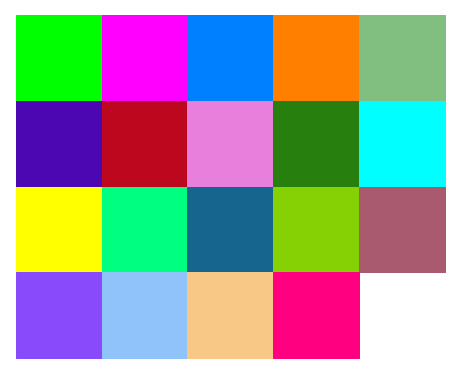

In [132]:
distinctipy.color_swatch(colors)

**Set precision for color values**

In [133]:
precision = 5

**Round color values to specified precision**

In [134]:
colors = [[np.round(ch, precision) for ch in color] for color in colors]
colors

[[0.0, 1.0, 0.0],
 [1.0, 0.0, 1.0],
 [0.0, 0.5, 1.0],
 [1.0, 0.5, 0.0],
 [0.5, 0.75, 0.5],
 [0.29867, 0.02733, 0.6966],
 [0.73642, 0.02778, 0.11759],
 [0.91335, 0.49693, 0.86555],
 [0.1538, 0.50086, 0.05228],
 [0.0, 1.0, 1.0],
 [1.0, 1.0, 0.0],
 [0.0, 1.0, 0.5],
 [0.08082, 0.39653, 0.55617],
 [0.52157, 0.81891, 0.01566],
 [0.66742, 0.35117, 0.43696],
 [0.53194, 0.28968, 0.98533],
 [0.56378, 0.76352, 0.98195],
 [0.97268, 0.78969, 0.52629],
 [1.0, 0.0, 0.5]]

**Annotate image using bounding box proposals**

(384, 512)


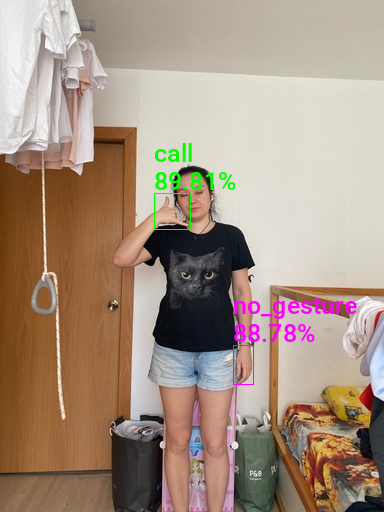

In [135]:
annotated_img = test_img.copy()
draw = ImageDraw.Draw(annotated_img)
fnt_size = 25
for i in proposal_indices:
    x, y, w, h, l, p = proposals[i].values()
    shape = (x, y, x+w, y+h)
    color = tuple([int(ch*255) for ch in colors[proposals[i]['label']]])
    draw.rectangle(shape, outline=color)
    fnt = PIL.ImageFont.truetype("KFOlCnqEu92Fr1MmEU9vAw.ttf", fnt_size)
    draw.multiline_text((x, y-fnt_size*2-5), f"{labels[l]}\n{p*100:.2f}%", font=fnt, fill=color)
print(annotated_img.size) 
annotated_img

**Benchmark OpenVINO IR CPU inference speed**

In [136]:
%%timeit
compiled_model_ir([input_image])[output_layer_ir]

12.8 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


**Create JSON color map**

In [137]:
color_map = {'items': list()}
color_map['items'] = [{'label': label, 'color': color} for label, color in zip(labels, colors)]
color_map

{'items': [{'label': 'call', 'color': [0.0, 1.0, 0.0]},
  {'label': 'no_gesture', 'color': [1.0, 0.0, 1.0]},
  {'label': 'dislike', 'color': [0.0, 0.5, 1.0]},
  {'label': 'fist', 'color': [1.0, 0.5, 0.0]},
  {'label': 'four', 'color': [0.5, 0.75, 0.5]},
  {'label': 'like', 'color': [0.29867, 0.02733, 0.6966]},
  {'label': 'mute', 'color': [0.73642, 0.02778, 0.11759]},
  {'label': 'ok', 'color': [0.91335, 0.49693, 0.86555]},
  {'label': 'one', 'color': [0.1538, 0.50086, 0.05228]},
  {'label': 'palm', 'color': [0.0, 1.0, 1.0]},
  {'label': 'peace', 'color': [1.0, 1.0, 0.0]},
  {'label': 'peace_inverted', 'color': [0.0, 1.0, 0.5]},
  {'label': 'rock', 'color': [0.08082, 0.39653, 0.55617]},
  {'label': 'stop', 'color': [0.52157, 0.81891, 0.01566]},
  {'label': 'stop_inverted', 'color': [0.66742, 0.35117, 0.43696]},
  {'label': 'three', 'color': [0.53194, 0.28968, 0.98533]},
  {'label': 'three2', 'color': [0.56378, 0.76352, 0.98195]},
  {'label': 'two_up', 'color': [0.97268, 0.78969, 0.5262

**Export color map**

In [139]:
import json

color_map_file_name = f"{dataset_path.name}-colormap.json"

with open(color_map_file_name, "w") as write_file:
    json.dump(color_map, write_file)
    
color_map_file_name

'hagrid-sample-30k-384p-colormap.json'

**Export color map for C++ command-line demo**

In [140]:
labels_cpp_file_name = f'{dataset_path.name}-labels-cpp.txt'
colormap_cpp_file_name = f'{dataset_path.name}-colormap-cpp.txt'

with open(labels_cpp_file_name, "w") as write_file:
    write_file.write(str(labels).replace("'", '"').replace("[", '{').replace("]", '}'))

with open(colormap_cpp_file_name, "w") as write_file:
    write_file.write(str(colors).replace("'", '"').replace("[", '{').replace("]", '}'))